# Distance determination in B1608

Jee et al point out that time delay lenses contain information about both the time delay distance $D_{\Delta t}$ and the angular diameter distance to the lens $D_{\rm d}$. These two quantities featured in the analysis of both B1608 and RXJ1131, and so we can visualize their contributions to the cosmological parameter inference by computing their posterior predictive distributions.

## Data Aquisition

Sherry Suyu has kindly provided the MCMC chains used in their B1608 analysis. Let's download  and plot them.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
%matplotlib inline
from __future__ import print_function

In [2]:
def are_samples_from(datfile,flat_cosmology=False):

    # Download data:
    baseurl = "http://www.slac.stanford.edu/~pjm/B1608/data/chains/"
    samples = pd.read_table(baseurl+datfile,header=0,names=["weight", "H0", "OmegaM", "OmegaDE", "w0", "Ddt", "gamma", "kext"])

    # Clean out zero weight samples:
    # samples = samples[samples["weight"] > 0.0]
    # print("Downloaded "+str(len(samples))+" samples with non-zero weight from "+baseurl+datfile)
    print("Downloaded "+str(len(samples))+" samples from "+baseurl+datfile)
    
    # Add a column for Omega_k, rounding off:
    samples['OmegaK'] = 1.0 - samples['OmegaM'] - samples['OmegaDE']
    # This gives some very small negative values, so optionally enforce flatness:
    if flat_cosmology: 
        samples['OmegaK'] = 0.0 
        samples['OmegaM'] = 1.0 - samples['OmegaDE']
        
    return samples

In [3]:
FLATUNIFORM = are_samples_from("tmpCombSamples_HQ_FLATUNIFORM_kextcounts_ACS.dat",flat_cosmology=True)

Downloaded 54298 samples from http://www.slac.stanford.edu/~pjm/B1608/data/chains/tmpCombSamples_HQ_FLATUNIFORM_kextcounts_ACS.dat


In [4]:
# K03 = are_samples_from("tmpCombSamples_HQ_K03_kextcounts_ACS.dat",flat_cosmology=True)

In [5]:
FLATUNIFORM.head()

,weight,H0,OmegaM,OmegaDE,w0,Ddt,gamma,kext,OmegaK
0,0,109.640280,0.095992,0.904008,-0.726214,3131.4612,2.104554,0.084626,0
1,0,102.869450,0.810549,0.189451,0.429494,3327.5162,2.099303,0.075959,0
2,0,105.305030,0.493564,0.506436,-1.554102,3545.7397,2.102358,0.149209,0
3,0,70.682263,0.520871,0.479129,-0.528740,4815.6164,2.101658,0.163801,0
4,0,98.882415,0.259888,0.740112,-2.199175,4407.0434,2.107153,0.457679,0


## Corner Plot

Let's first look at all our parameters, to see what's going on. We want to see posteriors from both models, and also the FLATUNIFORM prior.

In [6]:
import corner

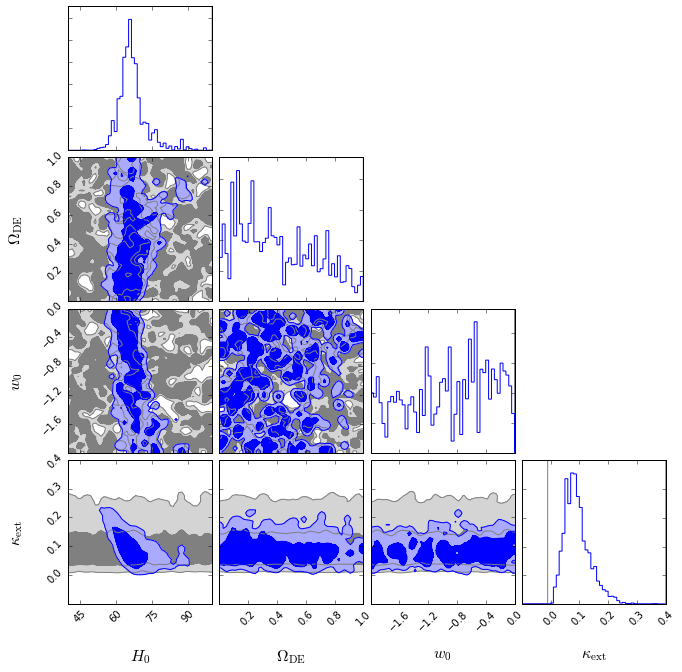

In [7]:
labels = np.array(['$H_0$','$\Omega_{\\rm DE}$','$w_0$','$\kappa_{\\rm ext}$'])
limits = range=[(40, 100), (0.0,1.0), (-2.0,0.0), (-0.1,0.4)]

plotFLATUNIFORM = np.atleast_2d(FLATUNIFORM.loc[:,['H0','OmegaDE','w0','kext']])
FLATUNIFORMimportances = np.ravel(FLATUNIFORM.loc[:,['weight']])

# plotK03 = np.atleast_2d(K03.loc[:,['H0','OmegaDE','w0','kext']])
# K03importances = np.ravel(K03.loc[:,['weight']])

fig = corner.corner(plotFLATUNIFORM, labels=labels, range=limits, color='gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});
corner.corner(plotFLATUNIFORM, weights=FLATUNIFORMimportances, fig=fig, labels=labels, range=limits, color='blue', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});

In [8]:
# This line could have been used to show the K03 constraints - but there is an exact degeneracy which does not display well...
# corner.corner(plotK03, weights=K03importances, fig=fig, labels=labels, range=limits, color='red', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});

# The K03 and FLATUNIFORM $H_0$ inferences are slightly offset from each other. 
# Note how the delta function in the K03 prior appears smoothed out in the plot... 

Now let's compute $D_{\Delta t}$ and $D_{\rm d}$ and plot them for each set of samples.

## Distance Predictions

First let's compute the time delay distance and compare with the `Ddt` column of in the data files.

In [9]:
from astropy import cosmology

def compute_distances(df,zd,zs):
    '''
    Add two extra columns to an input pandas dataframe, for the angular diameter distance
    to the lens, and the time delay distance of the system.
    '''
    N = len(df)
    Dd = np.zeros(N)
    Ds = np.zeros(N)
    Dds = np.zeros(N)
    Ddt = np.zeros(N)

    for k in np.arange(N):
        
        row = df.iloc[k]
        
        # Set the cosmology. Use a wCDM model, as described at http://docs.astropy.org/en/v0.3/api/astropy.cosmology.core.wCDM.html#astropy.cosmology.core.wCDM
        cosmological = cosmology.FlatwCDM(name='sample', H0=row['H0'], Om0=row['OmegaM'], w0=row['w0'])
        
        # Compute distances:        
        Dds[k] = cosmological.angular_diameter_distance_z1z2(zd, zs).value
        Ds[k] = cosmological.angular_diameter_distance(zs).value
        Dd[k] = cosmological.angular_diameter_distance(zd).value
        Ddt[k] = (1.0+zd)*Dd[k]*Ds[k]/Dds[k]

    # Add the finished arrays to the dataframe:
    df['Dd_p'] = Dd
    df['Ddt_p'] = Ddt
    
    # Show progress:
    m = 72 # line width...
    if np.mod(k,(N - np.mod(N,m))/m) == 0: print('.', end="",flush=True)

    return df

In [10]:
# Use B1608 redshifts, and compute distances in place:

zd, zs = 0.6304, 1.394

# compute_distances(K03,zd,zs);
compute_distances(FLATUNIFORM,zd,zs);

/Users/pjm/miniconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [11]:
FLATUNIFORM.head()

,weight,H0,OmegaM,OmegaDE,w0,Ddt,gamma,kext,OmegaK,Dd_p,Ddt_p
0,0,109.640280,0.095992,0.904008,-0.726214,3131.4612,2.104554,0.084626,0,915.161434,3131.525357
1,0,102.869450,0.810549,0.189451,0.429494,3327.5162,2.099303,0.075959,0,749.560736,3327.511584
2,0,105.305030,0.493564,0.506436,-1.554102,3545.7397,2.102358,0.149209,0,914.672678,3545.731455
3,0,70.682263,0.520871,0.479129,-0.528740,4815.6164,2.101658,0.163801,0,1220.323621,4815.669162
4,0,98.882415,0.259888,0.740112,-2.199175,4407.0434,2.107153,0.457679,0,1208.810718,4407.007463


First let's double check the time delay distances, and remove the ones that have not been well calculated:

In [12]:
def clean_distances(df,tol=1.0):
    x = df['Ddt'] - df['Ddt_p']
    good, bad = (np.abs(x) <= tol), (np.abs(x) > tol) # Tolerance in Mpc
    print("No. of bad samples = ",len(x[bad]))
    df = df.loc[good]
    x = df['Ddt'] - df['Ddt_p']
    print("Difference between catalogued and computed time delay distances is",round(np.mean(x),1),"+/-",round(np.std(x),1),"Mpc")
    return df

In [13]:
FLATUNIFORM = clean_distances(FLATUNIFORM)
# K03 = clean_distances(K03)

No. of bad samples =  10225
Difference between catalogued and computed time delay distances is -0.0 +/- 0.2 Mpc


Good. Now, let's plot the distances against each other. 

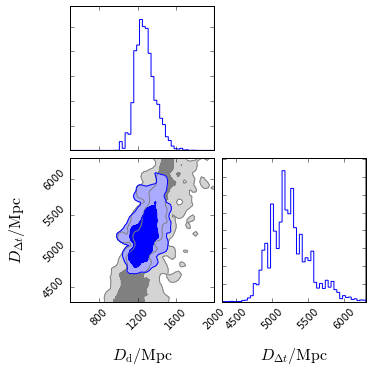

In [14]:
labels = np.array(['$D_{\\rm d} / {\\rm Mpc}$','$D_{\Delta t} / {\\rm Mpc}$'])
limits = range=[(500, 2000), (4300,6300)]

# Make plottable sub-arrays:
plotFLATUNIFORM = np.atleast_2d(FLATUNIFORM.loc[:,['Dd_p','Ddt_p']])
FLATUNIFORMimportances = np.ravel(FLATUNIFORM.loc[:,['weight']])

# plotK03 = np.atleast_2d(K03.loc[:,['Dd_p','Ddt_p']])
# K03importances = np.ravel(K03.loc[:,['weight']])

# Plot:
fig = corner.corner(plotFLATUNIFORM, labels=labels, range=limits, color='gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});
corner.corner(plotFLATUNIFORM, weights=FLATUNIFORMimportances, fig=fig, labels=labels, range=limits, color='blue', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});

In [15]:
# Another unused overlay:
# corner.corner(plotK03, weights=K03importances, fig=fig, labels=labels, range=limits, color='red', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});

The two distances are correlated, even in the prior: uniform distributions for cosmological parameters give rise to correlated PDFs for the distances. In the K03 case, the degeneracy has zero scatter, since there is only one free cosmological parameter involved ($H_0$).

Let's replot, offsetting to the mean, and computing the percentage uncertainty via the standard deviation of the samples. First we'll need a function for computing weighted means and standard deviations (taking care with the array operations).

In [16]:
def distance_mean_and_stdev(df):
    
    x = np.atleast_2d(df.loc[:,['Dd_p','Ddt_p']])
    w = np.atleast_1d(df.loc[:,['weight']])
 
    sum_w   = np.matrix(w).sum(0)[0,0]
    sum_wx  = np.ravel(np.matrix(w*x).sum(0))
    sum_wx2 = np.ravel(np.matrix(w*x*x).sum(0))
    N = len(x)

    mean = sum_wx / sum_w
    var = (sum_wx2 - 2.0*mean*sum_wx + mean*mean*sum_w) / (sum_w * (N-1)/N)
    stdv = np.sqrt(var)
    
    return mean,stdv

Now we can make the plottable sub-arrays, rescale, and plot. Let's look at the precision in each case as we go.

In [17]:
mean,stdv = distance_mean_and_stdev(FLATUNIFORM)
print("FLATUNIFORM: D_d  precision = ",np.round(100*stdv[0]/mean[0], 1),"%")
print("FLATUNIFORM: D_dt precision = ",np.round(100*stdv[1]/mean[1], 1),"%")

percentageplotFLATUNIFORM = (100.0*(np.atleast_2d(FLATUNIFORM.loc[:,['Dd_p','Ddt_p']]) - mean)/mean)

FLATUNIFORM: D_d  precision =  8.1 %
FLATUNIFORM: D_dt precision =  5.6 %


In [18]:
# mean,stdv = distance_mean_and_stdev(K03)
# print("K03: D_d  precision = ",np.round(100*stdv[0]/mean[0], 1),"%")
# print("K03: D_dt precision = ",np.round(100*stdv[1]/mean[1], 1),"%")
# 
# percentageplotK03 = (100.0*(np.atleast_2d(K03.loc[:,['Dd_p','Ddt_p']]) - mean)/mean)

For the plot, let's leave off the K03 contours - we know they will just show a zero-scatter degeneracy. The interesting comparison is FLATUNIFORM posterior with FLATUNIFORM prior.

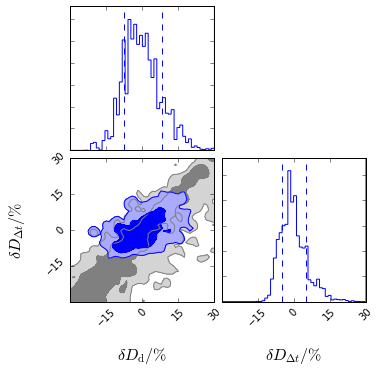

In [22]:
labels = np.array(['$\\delta D_{\\rm d} / \\%$','$\\delta D_{\Delta t} / \\%$'])
limits = range=[(-30, 30), (-30,30)]

# quantiles=[0.16, 0.84],show_titles=True, 

fig = corner.corner(percentageplotFLATUNIFORM, labels=labels, range=limits, color='gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});
corner.corner(percentageplotFLATUNIFORM, weights=FLATUNIFORMimportances, fig=fig, quantiles=[0.16, 0.84], labels=labels, range=limits, color='blue', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16});

## Interpretation

In the K03 cosmology, there is only one free parameter: $H_0$. In this case, the time delay distance and angular diameter distance are perfectly correlated (the smoothing hides this, in the plots).

In the FLATUNIFORM cosmology, B1608 provides very little constraint on $\Omega_{\rm DE}$ and $w_0$, but the two distances must still be mutually consistent, within the world model we are assuming. This makes them partially correlated. If we had assumed uniform priors on the distances, rather than the cosmological parameters, we may well not see any correlation (as Sherry has shown in her priv. comm. plot). 

The constraints from the B1608 lensing and velocity dispersion data (along with the assumptions that were made in that analysis) give rise to precise predictions of both time delay distance and lens angular diameter distance (which both appear in the likelihood function), at the level of 5.7% and 8.1% respectively.  

The FLATUNIFORM posterior (blue) does not look exactly like the prior (gray) multiplied by a likelihood function that only depends on $D_{\Delta t}$ (although it's close): there seems to be *some* constraint in $D_{\rm d}$ as well, as predicted by Jee et al. However, for B1608 the (log-normal) approximation to the "time delay distance likelihood" seems reasonable. With better kinematic data this may no longer be true.

In [23]:
fig.savefig('B1608_DdtDa.pdf')